# Braille detection with CNN

In this script we create, train and evaluate an image classifier based on convolutional networks.

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset, DataLoader
import fnmatch
from skimage import io, transform
import torchvision
import pandas as pd

# Define the device and data repository
device = 'cpu'
data_dir = 'dataset/'

# Data management

We read data, split it onto train, val and test and create data loaders with preprocessing.

In [53]:
# We start by creating a class object for representing our image data
# This is a subclass of torch.utils.data.dataset.Dataset that will serve as input to the DataLoader

class ImageDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        """Here we initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        self.classes = [filename.split("/")[-1][0] for filename in self.image_files]
        self.let2num = {a: i for i, a in enumerate(sorted(list(set(self.classes))))}
        self.num2let = {i: a for a, i in self.let2num.items()}
        
        self.transform = transform
        
    def letter_to_number(self, let):
        return self.let2num[let]
    
    def number_to_letter(self, num):
        return self.num2let[num]
    

    def __len__(self):
        """Here we return the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample for a given index."""
        # TO DO: write this function: it takes as input 'index' (which is an integer number),
        # and returns the corresponding item as a pytorch tensor
        # hint: use 'self.image_files' , which is the list of images paths defined in the '__init__' method
        filename = self.image_files[index]
        x = io.imread(filename)
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.classes[index]

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files


In [54]:
#to divide: torch.utils.data.random_split(dataset, lengths)
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      mean=(0.5, 0.5, 0.5), 
                                                      std=(0.3,0.3,0.3))])

In [55]:
dataset = ImageDataset(image_dir=data_dir, transform=data_transforms)

In [56]:
len(set(dataset.classes))

26

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


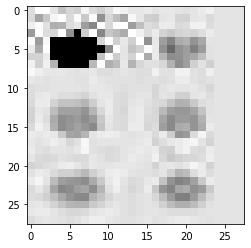

In [57]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [58]:
dataset[0][0].size()

torch.Size([3, 28, 28])

In [59]:
dataset.letter_to_number(dataset[0][1])

0

In [60]:
dataset.number_to_letter(0)

'a'

In [61]:
dataset_ln = len(dataset)
train_ln, val_ln, test_ln = int(dataset_ln * 0.8), int(dataset_ln * 0.1), int(dataset_ln * 0.1)

In [62]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_ln, val_ln, test_ln], generator=torch.Generator().manual_seed(42))

In [63]:
len(val_data)

156

In [64]:
val_data[1]

(tensor([[[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ...,

In [65]:
def collate_fn(data):
    images, labels = zip(*data)
    
    labels = [dataset.letter_to_number(label) for label in labels]
    return torch.stack(images).float(), torch.tensor(labels).long()


In [66]:
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)


# Useful functions for training, validation and testing

In [67]:
def train_model(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, 
                device='cpu', verbose=True, model_name='simple', optim='SGD', cells=False):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    last_best_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #print(labels)
            #print(images.size(), labels.size(), labels)
            images = images.to(device)
            if cells:
                new_labels = torch.zeros((len(labels), 6))
                for i, l in enumerate(labels):
                    new_labels[i] = torch.tensor(list(map(int, braille_map[dataset.number_to_letter(l.item())]))).float()
                labels = new_labels
            else:
                labels = labels.to(device)
            
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_current_epoch += loss.item()
            
        cur_acc = eval_model(model, valid_dataloader)
        if cur_acc > last_best_acc:
            last_best_acc = cur_acc
            torch.save(model.state_dict(), f'models/model_{model_name}_best.pt')
            print("\nNew best accuracy! ", last_best_acc)
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('\rEpoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch), end='')
        
    return model, loss_all_epochs

In [68]:
def eval_model(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [69]:
all_results = {"Model":[], "Loss":[], "Optimizer":[], "lr":[], "Accuracy":[]}

# First model

In [70]:
# Define a CNN classifier module.

class CNNSimpleClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        super(CNNSimpleClassif, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.res = nn.Linear(size_vec, num_classes)
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(x)
        return out

## Experiments

In [71]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)


New best accuracy!  48.717948717948715
Epoch [1/20], Loss: 408.7961
New best accuracy!  54.48717948717949
Epoch [2/20], Loss: 254.3919
New best accuracy!  58.333333333333336
Epoch [3/20], Loss: 200.4747
New best accuracy!  62.82051282051282
Epoch [4/20], Loss: 169.2062
New best accuracy!  63.46153846153846
Epoch [5/20], Loss: 148.2105
New best accuracy!  66.66666666666667
Epoch [6/20], Loss: 130.7587
New best accuracy!  67.94871794871794
Epoch [7/20], Loss: 116.1132
New best accuracy!  73.07692307692308
Epoch [9/20], Loss: 92.80303
New best accuracy!  75.64102564102564
Epoch [10/20], Loss: 82.4789
New best accuracy!  78.84615384615384
Epoch [12/20], Loss: 65.1175
New best accuracy!  79.48717948717949
Epoch [18/20], Loss: 33.4843
New best accuracy!  82.05128205128206
Epoch [20/20], Loss: 27.5399

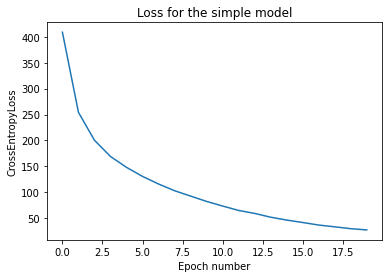

In [72]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple.pt')
plt.plot(loss_total)



plt.title("Loss for the simple model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_loss.png")
plt.show() 

In [73]:
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)

model.load_state_dict(torch.load('models/model_simple_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

82.6923076923077


In [74]:
all_results["Model"].append("simple")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Second model

In [75]:
# Define a CNN classifier module.

class CNNSimple6Cells(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        super(CNNSimple6Cells, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.lin6 = nn.Sequential(nn.Linear(size_vec, 6), nn.ReLU())
        self.res = nn.Sequential(nn.Linear(6, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, num_classes))
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(self.lin6(x))
        return out


New best accuracy!  7.051282051282051
Epoch [1/40], Loss: 487.7721
New best accuracy!  29.487179487179485
Epoch [2/40], Loss: 389.7966
New best accuracy!  35.8974358974359
Epoch [3/40], Loss: 301.8417
New best accuracy!  41.666666666666664
Epoch [4/40], Loss: 236.2718
New best accuracy!  56.41025641025641
Epoch [5/40], Loss: 202.0149
New best accuracy!  62.82051282051282
Epoch [6/40], Loss: 162.9467
New best accuracy!  64.1025641025641
Epoch [7/40], Loss: 142.0918
New best accuracy!  67.94871794871794
Epoch [8/40], Loss: 128.1954
New best accuracy!  68.58974358974359
Epoch [12/40], Loss: 84.10926
New best accuracy!  73.07692307692308
Epoch [13/40], Loss: 84.1229
New best accuracy!  80.12820512820512
Epoch [20/40], Loss: 52.7845
New best accuracy!  80.76923076923077
Epoch [21/40], Loss: 54.4284
New best accuracy!  83.33333333333333
Epoch [26/40], Loss: 47.0919
New best accuracy!  83.97435897435898
Epoch [27/40], Loss: 41.2125
New best accuracy!  85.8974358974359
Epoch [37/40], Loss: 22

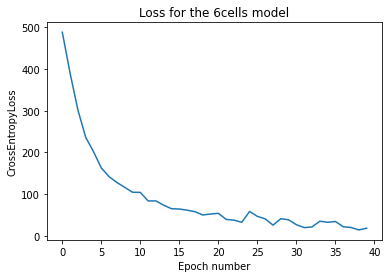

In [76]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.003

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells", optim='Adam')

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple_6_cells.pt')
plt.plot(loss_total)

plt.title("Loss for the 6cells model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_6cells_loss.png") 
plt.show()


In [77]:
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

model.load_state_dict(torch.load('models/model_6cells_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

85.8974358974359


In [78]:
all_results["Model"].append("6cells")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("Adam")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Third model

In [79]:
braille_map = {"a":"100000", "b":"110000", "c":"100100", "d":"100110", "e":"100010",
               "f":"110100", "g":"110110", "h":"110010", "i":"010100", "j":"101000",
               "k":"111000", "l":"101100", "m":"101110", "n":"101110", "o":"101010",
               "p":"111100", "q":"111110", "r":"111010", "s":"011100", "t":"011110",
               "u":"101001", "v":"111001", "w":"010111", "x":"101101", "y":"101111",
               "z":"101011"}

In [80]:
braille_map_rev = {v:k for k, v in braille_map.items()}

In [81]:
# Define a CNN classifier module.

class CNNSimple6CellsMap(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32):
        super(CNNSimple6CellsMap, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.res = nn.Linear(size_vec, 6)
        self.finact = nn.Sigmoid()
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.finact(self.res(x))
        if self.training:
            return out
        else:
            res = []
            for t in out:
                key = "".join(map(lambda a: str(a.item()), torch.round(t).long()))
                if key not in braille_map_rev:
                    res.append(0)
                    continue
                res.append(dataset.letter_to_number(braille_map_rev[key]))
            res = nn.functional.one_hot(torch.tensor(res), num_classes=26)
            return res

## Experiments


New best accuracy!  49.35897435897436
Epoch [1/40], Loss: 62.8884
New best accuracy!  55.12820512820513
Epoch [2/40], Loss: 45.3403
New best accuracy!  58.97435897435897
Epoch [4/40], Loss: 33.6589
New best accuracy!  59.61538461538461
Epoch [5/40], Loss: 29.5588
New best accuracy!  62.17948717948718
Epoch [6/40], Loss: 25.5890
New best accuracy!  67.94871794871794
Epoch [7/40], Loss: 22.6106
New best accuracy!  71.15384615384616
Epoch [8/40], Loss: 20.1710
New best accuracy!  73.71794871794872
Epoch [10/40], Loss: 15.8412
New best accuracy!  75.0
Epoch [11/40], Loss: 14.3336
New best accuracy!  76.28205128205128
Epoch [15/40], Loss: 8.93820
New best accuracy!  76.92307692307692
Epoch [16/40], Loss: 7.8999
New best accuracy!  77.56410256410257
Epoch [27/40], Loss: 2.2834
New best accuracy!  78.2051282051282
Epoch [40/40], Loss: 1.0155

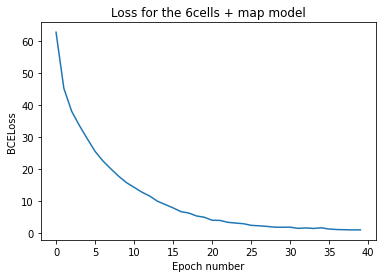

In [82]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimple6CellsMap(num_channels1, num_channels2)

# Optimizer
num_epochs = 40
loss_fn = nn.BCELoss()
learning_rate = 0.01

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells_map", optim='SGD', cells=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_6_cells_map.pt')

plt.title("Loss for the 6cells + map model")
plt.xlabel("Epoch number")
plt.ylabel("BCELoss")

plt.plot(loss_total)
plt.savefig("plots/model_simple_6cells_map_loss.png") 
plt.show()

In [83]:
model = CNNSimple6CellsMap(num_channels1, num_channels2)

model.load_state_dict(torch.load('models/model_6cells_map_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

76.92307692307692


In [84]:
all_results["Model"].append("6cells_map")
all_results["Loss"].append("BCELoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

In [85]:
df_results = pd.DataFrame(all_results)

In [86]:
df_results.to_csv("evaluation_results.csv")

In [87]:
df_results

,Model,Loss,Optimizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,82.692308
1,6cells,CrossEntropyLoss,Adam,0.003,85.897436
2,6cells_map,BCELoss,SGD,0.010,76.923077


In [179]:
pd.read_csv("evaluation_results.csv", index_col=0)

,Model,Loss,Optmizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,78.205128
1,6cells,CrossEntropyLoss,Adam,0.003,89.743590
2,6cells_map,BCELoss,SGD,0.010,75.000000
